In [14]:
import numpy as np
import pandas as pd

In [15]:
class Dataset:
    def __init__(self, dataset_path=None):
        self.path = dataset_path

    def get_data(self):
        data = pd.read_csv(self.path).to_numpy()
        X, Y_str = data[:, :-1], data[:, -1]  # remove the target column from the input and extract our targets
        # n_classes = len(set(Y_str))
        n_examples = len(Y_str)
        Y = np.zeros(n_examples)
        for i in range(len(Y_str)):
            category = Y_str[i]
            if category == "banana": Y[i] = 0
            elif category == "carrot": Y[i] = 1
            elif category == "cucumber": Y[i] = 2
            elif category == "mandarin": Y[i] = 3
            else: Y[i] = 4
        return X, Y


In [16]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iters=1000):
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.weights = None
        self.bias = None
        self.loss_hist = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict_raw(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def predict_proba(self, X):
        return self.sigmoid(self.predict_raw(X))
    
    def logisticLoss(self, y_true, y_pred):
        """
            binary cross entropy
        """
        y0 = y_true * np.log(y_pred)
        y1 = (1 - y_true) * np.log(1 - y_pred)
        return -np.mean(y0 + y1)
    
    def train(self, X_train, Y_train, X_val=None, Y_val=None):
        # Set the proper data type to avoid errors with numpy
        X_train, Y_train = X_train.astype(float), Y_train.astype(float)
        X_val = X_val.astype(float) if X_val is not None else None
        Y_val = Y_val.astype(float) if Y_val is not None else None
        # Normalize the features
        X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
        X_val   = (X_val - X_val.mean(axis=0)) / X_val.std(axis=0)


        n_examples, n_features = X_train.shape

        self.weights        = np.zeros(n_features)
        self.bias           = 0
        self.loss_hist      = []
        self.val_loss_hist  = []
        
        for i in range(self.num_iters):
            # Forward
            y_pred = self.sigmoid(np.dot(X_train, self.weights) + self.bias)
            train_loss = self.logisticLoss(Y_train, y_pred)

            # gradient of binary cross entropy
            y_diff = (y_pred - Y_train)
            self.weights -= self.learning_rate * np.dot(X_train.T, y_diff) / n_examples
            self.bias    -= self.learning_rate * np.mean(y_diff)
            
            # Save loss
            self.loss_hist.append(train_loss)

            # Validation
            if X_val is not None:
                val_pred = self.predict_proba(X_val)
                self.val_loss_hist.append(self.logisticLoss(Y_val, val_pred))

In [17]:
class LogisticRegressionOVA:
    def __init__(self, learning_rate=0.01, num_iters=1000):
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.models = []
        self.classes = None

    def train(self, X_train, Y_train, X_val=None, Y_val=None):
        self.classes = np.unique(Y_train)
        self.models = []

        for cls in self.classes:
            print(f"Train class {cls} vs rest")
            Y_binary_train  = (Y_train == cls).astype(float)
            Y_binary_val    = (Y_val == cls).astype(float) if Y_val is not None else None
            
            model = LogisticRegression(learning_rate=self.learning_rate, num_iters=self.num_iters)
            model.train(X_train, Y_binary_train, X_val, Y_binary_val)
            self.models.append(model)

    def predict(self, X):
        # Data type and normalization
        X = X.astype(float)
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        all_probs = []

        for model in self.models:
            probs = model.predict_proba(X)
            all_probs.append(probs)

        all_probs = np.column_stack(all_probs)
        max_idx = np.argmax(all_probs, axis=1)
        return self.classes[max_idx]

In [18]:
import matplotlib.pyplot as plt

def plot_ova_loss(models, classes, feature_set):
    plt.figure(figsize=(10, 6))

    for model, cls in zip(models, classes):
        plt.plot(model.loss_hist, label=f"Train Loss (class {cls})")
        if len(model.val_loss_hist) > 0:
            plt.plot(model.val_loss_hist, '--', label=f"Val Loss (class {cls})")

    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Training vs Validation Loss ({feature_set})")
    plt.legend()
    plt.grid()
    plt.show()


In [19]:
# Load all 4 feature sets
def load_split(split_name, features):
    path = f"./data/tabular/{split_name}_{features}_processed.csv"
    ds = Dataset(path)
    return ds.get_data()

# List of feature set
feature_sets = [
    "images",
    "tabular",
    "text",
    "fusion"
]

trained_models = {}

for name in feature_sets:
    print(f"Training model for feature set: {name}")

    # Load feature-specific data
    X_train, Y_train = load_split("train", name)
    X_val,   Y_val   = load_split("validation", name)
    X_test,  Y_test  = load_split("test", name)

    # Train OVA classifier
    model = LogisticRegressionOVA(learning_rate=0.01, num_iters=1000)
    model.train(X_train, Y_train, X_val, Y_val)

    # Save in dictionary
    trained_models[name] = {
        "model": model,
        "feature_set": name,
        "train_pred": model.predict(X_train),
        "val_pred": model.predict(X_val),
        "test_pred": model.predict(X_test),
        "Y_train": Y_train,
        "Y_val": Y_val,
        "Y_test": Y_test
    }

print("All four models are trained.")

Training model for feature set: images
Train class 0.0 vs rest
Train class 1.0 vs rest
Train class 2.0 vs rest
Train class 3.0 vs rest
Train class 4.0 vs rest
Training model for feature set: tabular
Train class 0.0 vs rest
Train class 1.0 vs rest
Train class 2.0 vs rest
Train class 3.0 vs rest
Train class 4.0 vs rest
Training model for feature set: text
Train class 0.0 vs rest
Train class 1.0 vs rest
Train class 2.0 vs rest
Train class 3.0 vs rest
Train class 4.0 vs rest
Training model for feature set: fusion
Train class 0.0 vs rest
Train class 1.0 vs rest
Train class 2.0 vs rest
Train class 3.0 vs rest
Train class 4.0 vs rest
All four models are trained.



Plotting losses for feature set: images


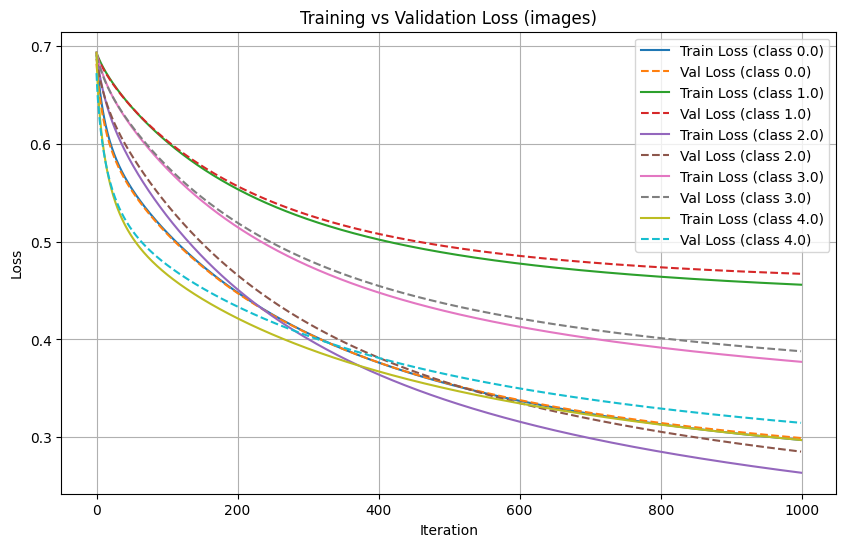


Plotting losses for feature set: tabular


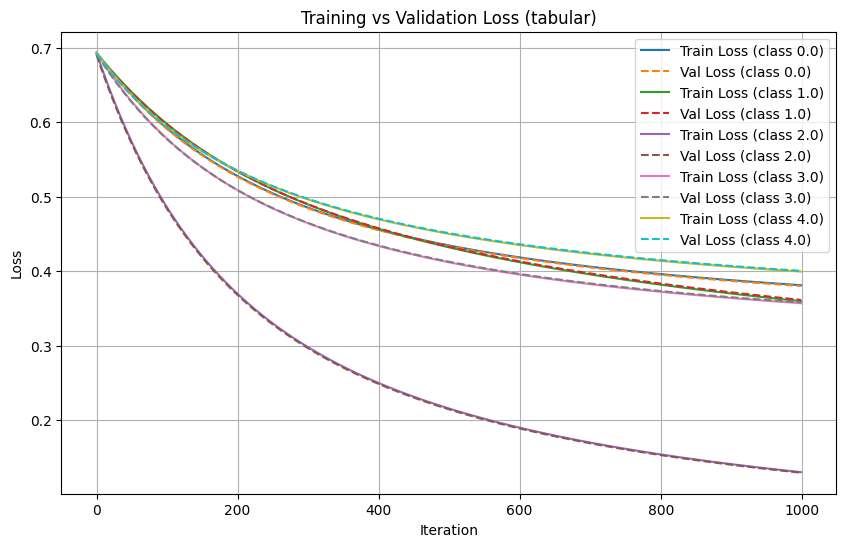


Plotting losses for feature set: text


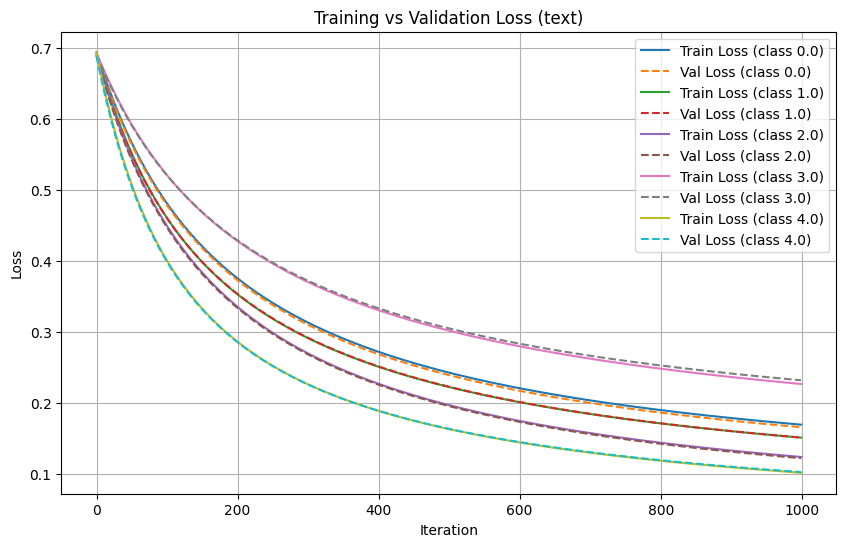


Plotting losses for feature set: fusion


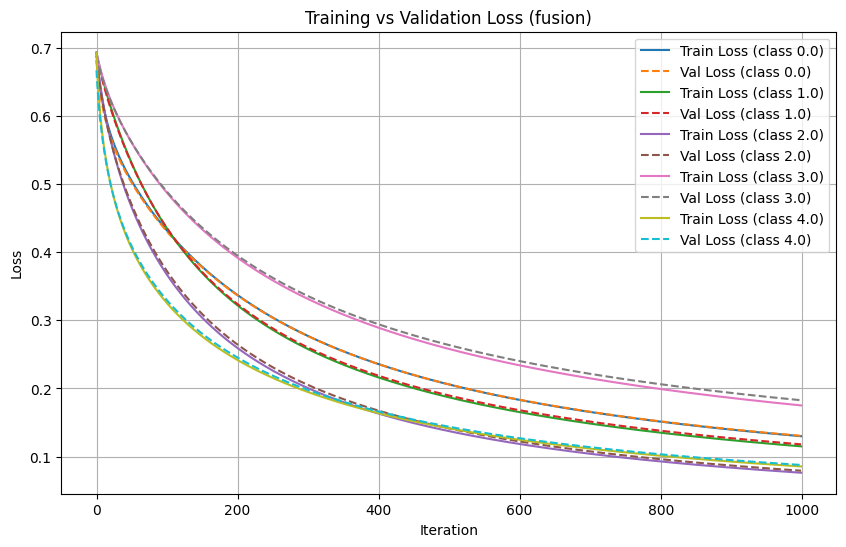

In [21]:
for name, data in trained_models.items():
    print(f"\nPlotting losses for feature set: {name}")
    plot_ova_loss(data["model"].models, data["model"].classes, data["feature_set"])